In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [23]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [24]:
## update data
def filter_df(df):
    thresh=8
    age_counts = df.index.get_level_values('age').value_counts()
    ages_greater = list(age_counts[age_counts > thresh].index)
    return df.loc[df.index.get_level_values('age').isin(ages_greater)]

In [25]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

#from matplotlib.colors import LinearSegmentedColormap
# Define the color map
#colors = ['#dadaeb','#6a51a3']
#custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
#cmm=custom_cmap

In [26]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks
sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_male = pd.concat([sample,sample2])
df_male.rename(columns={'binned_age': 'age'}, inplace=True)

df_male.set_index(['age', 'mouse'], inplace=True)

In [27]:
format_plots()

In [28]:
# avarage per age or session
m_df=df_male.groupby(['age','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Assuming m_df is your DataFrame with MultiIndex (mouse, age) and 60 measurement columns

def calculate_acf(m_df, nlags=20):
    mice = m_df.index.get_level_values('mouse').unique()
    measurements = m_df.columns
    acf_results = {measurement: [] for measurement in measurements}
    
    for mouse in mice:
        for measurement in measurements:
            try:
                individual_data = m_df.xs(mouse, level='mouse')[measurement].sort_index()
                autocorr_values = acf(individual_data, nlags=nlags)
                acf_results[measurement].append(autocorr_values)
            except KeyError as e:
                print(f'Error processing {mouse} - {measurement}: {e}')
    
    return acf_results

acf_results = calculate_acf(m_df, nlags=20)

In [30]:
def aggregate_acf(acf_results, nlags=20):
    aggregated_acf = {}
    
    for measurement, acf_values in acf_results.items():
        # Convert list of acf arrays to a DataFrame for easy aggregation
        acf_df = pd.DataFrame(acf_values)
        # Calculate mean autocorrelation for each lag
        mean_acf = acf_df.mean(axis=0)
        aggregated_acf[measurement] = mean_acf
    
    return aggregated_acf

aggregated_acf = aggregate_acf(acf_results, nlags=20)

/tmp/ipykernel_21271/1029713114.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


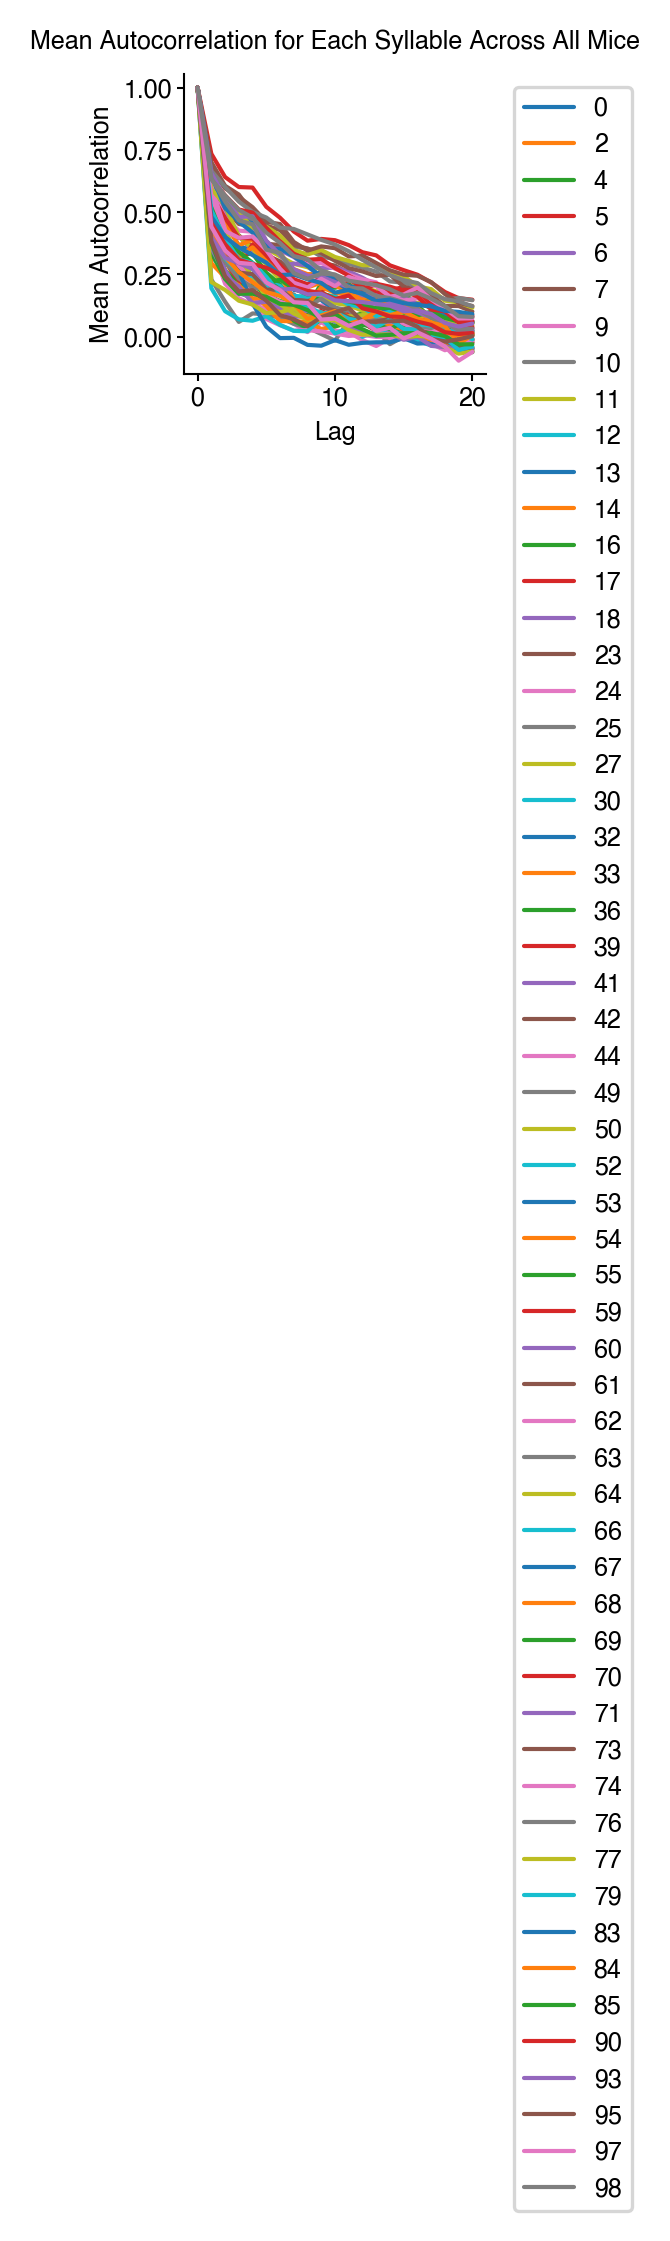

In [31]:
def plot_aggregated_acf(aggregated_acf, nlags=20):
    fig = figure(1.3, 1.3)
    #plt.figure(figsize=(12, 8))
    
    for measurement, mean_acf in aggregated_acf.items():
        plt.plot(range(nlags+1), mean_acf, label=measurement)
    
    plt.xlabel('Lag')
    plt.ylabel('Mean Autocorrelation')
    plt.title('Mean Autocorrelation for Each Syllable Across All Mice')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    sns.despine()
    plt.show()
    c = PlotConfig()
    fig.savefig(c.dana_save_path / "fig4"/ 'autocorr_decay_line_longv2_male.pdf')

plot_aggregated_acf(aggregated_acf, nlags=20)

In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf

# Assuming m_df is your DataFrame with MultiIndex (mouse, age) and 60 measurement columns

def calculate_acf(m_df, nlags=20):
    mice = m_df.index.get_level_values('mouse').unique()
    measurements = m_df.columns
    acf_results = {measurement: [] for measurement in measurements}
    
    for mouse in mice:
        for measurement in measurements:
            try:
                individual_data = m_df.xs(mouse, level='mouse')[measurement].sort_index()
                autocorr_values = acf(individual_data, nlags=nlags)
                acf_results[measurement].append(autocorr_values)
            except KeyError as e:
                print(f'Error processing {mouse} - {measurement}: {e}')
    
    return acf_results

acf_results = calculate_acf(m_df, nlags=20)

In [13]:

def calculate_decay_values(acf_results, threshold=0.5, nlags=20):
    decay_values = {measurement: [] for measurement in acf_results}
    
    for measurement, acf_list in acf_results.items():
        for acf_values in acf_list:
            decay_lag = next((lag for lag, value in enumerate(acf_values) if value < threshold), nlags)
            decay_values[measurement].append(decay_lag)
    
    return decay_values

decay_values = calculate_decay_values(acf_results, threshold=0.5, nlags=20)

In [14]:
def aggregate_decay_values(decay_values):
    aggregated_decay = {}
    
    for measurement, decay_list in decay_values.items():
        mean_decay = np.mean(decay_list)
        aggregated_decay[measurement] = mean_decay
    
    return aggregated_decay

aggregated_decay = aggregate_decay_values(decay_values)

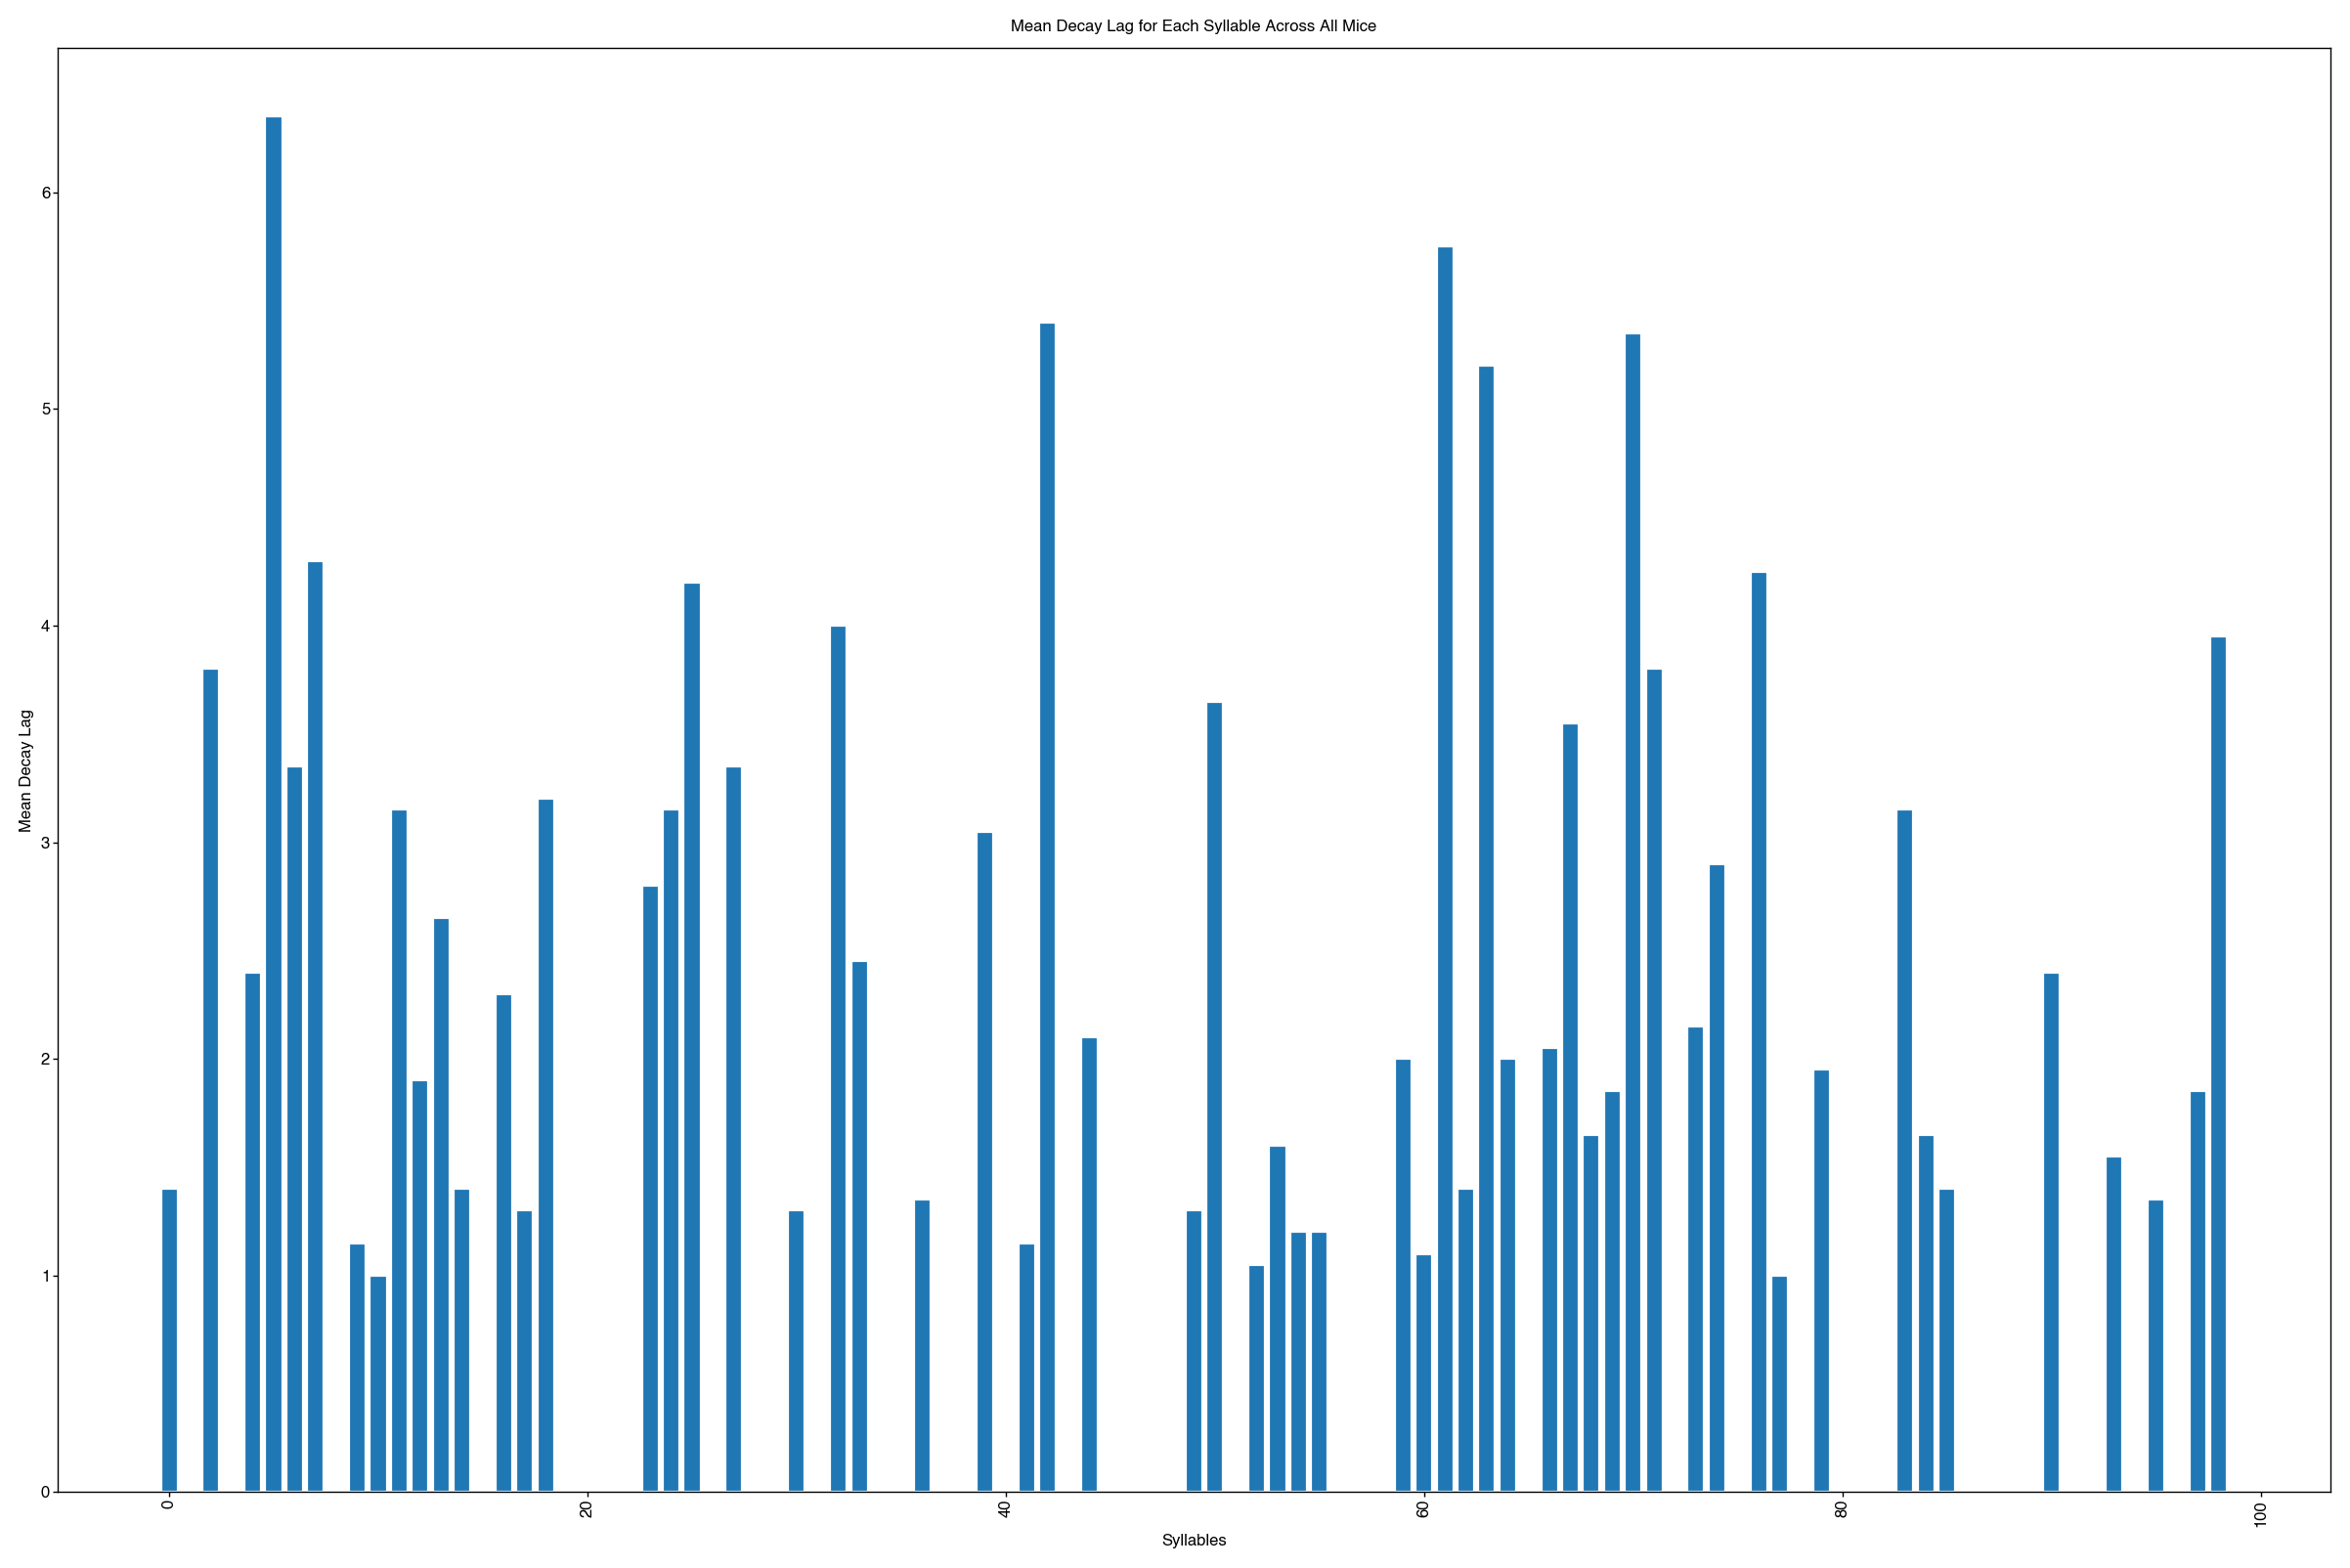

In [15]:
import matplotlib.pyplot as plt

def plot_aggregated_decay(aggregated_decay):
    measurements = list(aggregated_decay.keys())
    decay_means = list(aggregated_decay.values())
    
    plt.figure(figsize=(12, 8))
    plt.bar(measurements, decay_means)
    plt.xlabel('Syllables')
    plt.ylabel('Mean Decay Lag')
    plt.title('Mean Decay Lag for Each Syllable Across All Mice')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_aggregated_decay(aggregated_decay)

In [16]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf

# Assuming m_df is your DataFrame with MultiIndex (mouse, age) and 60 measurement columns

def calculate_acf(m_df, nlags=20):
    mice = m_df.index.get_level_values('mouse').unique()
    measurements = m_df.columns
    acf_results = {measurement: [] for measurement in measurements}
    
    for mouse in mice:
        for measurement in measurements:
            try:
                individual_data = m_df.xs(mouse, level='mouse')[measurement].sort_index()
                autocorr_values = acf(individual_data, nlags=nlags)
                acf_results[measurement].append(autocorr_values)
            except KeyError as e:
                print(f'Error processing {mouse} - {measurement}: {e}')
    
    return acf_results

acf_results = calculate_acf(m_df, nlags=20)

In [17]:
def calculate_decay_values(acf_results, threshold=0.5, nlags=20):
    decay_values = {measurement: [] for measurement in acf_results}
    
    for measurement, acf_list in acf_results.items():
        for acf_values in acf_list:
            decay_lag = next((lag for lag, value in enumerate(acf_values) if value < threshold), nlags)
            decay_values[measurement].append(decay_lag)
    
    return decay_values

decay_values = calculate_decay_values(acf_results, threshold=0.5, nlags=20)

In [18]:
def aggregate_decay_values(decay_values):
    aggregated_decay = {}
    
    for measurement, decay_list in decay_values.items():
        mean_decay = np.mean(decay_list)
        aggregated_decay[measurement] = mean_decay
    
    return aggregated_decay

aggregated_decay = aggregate_decay_values(decay_values)

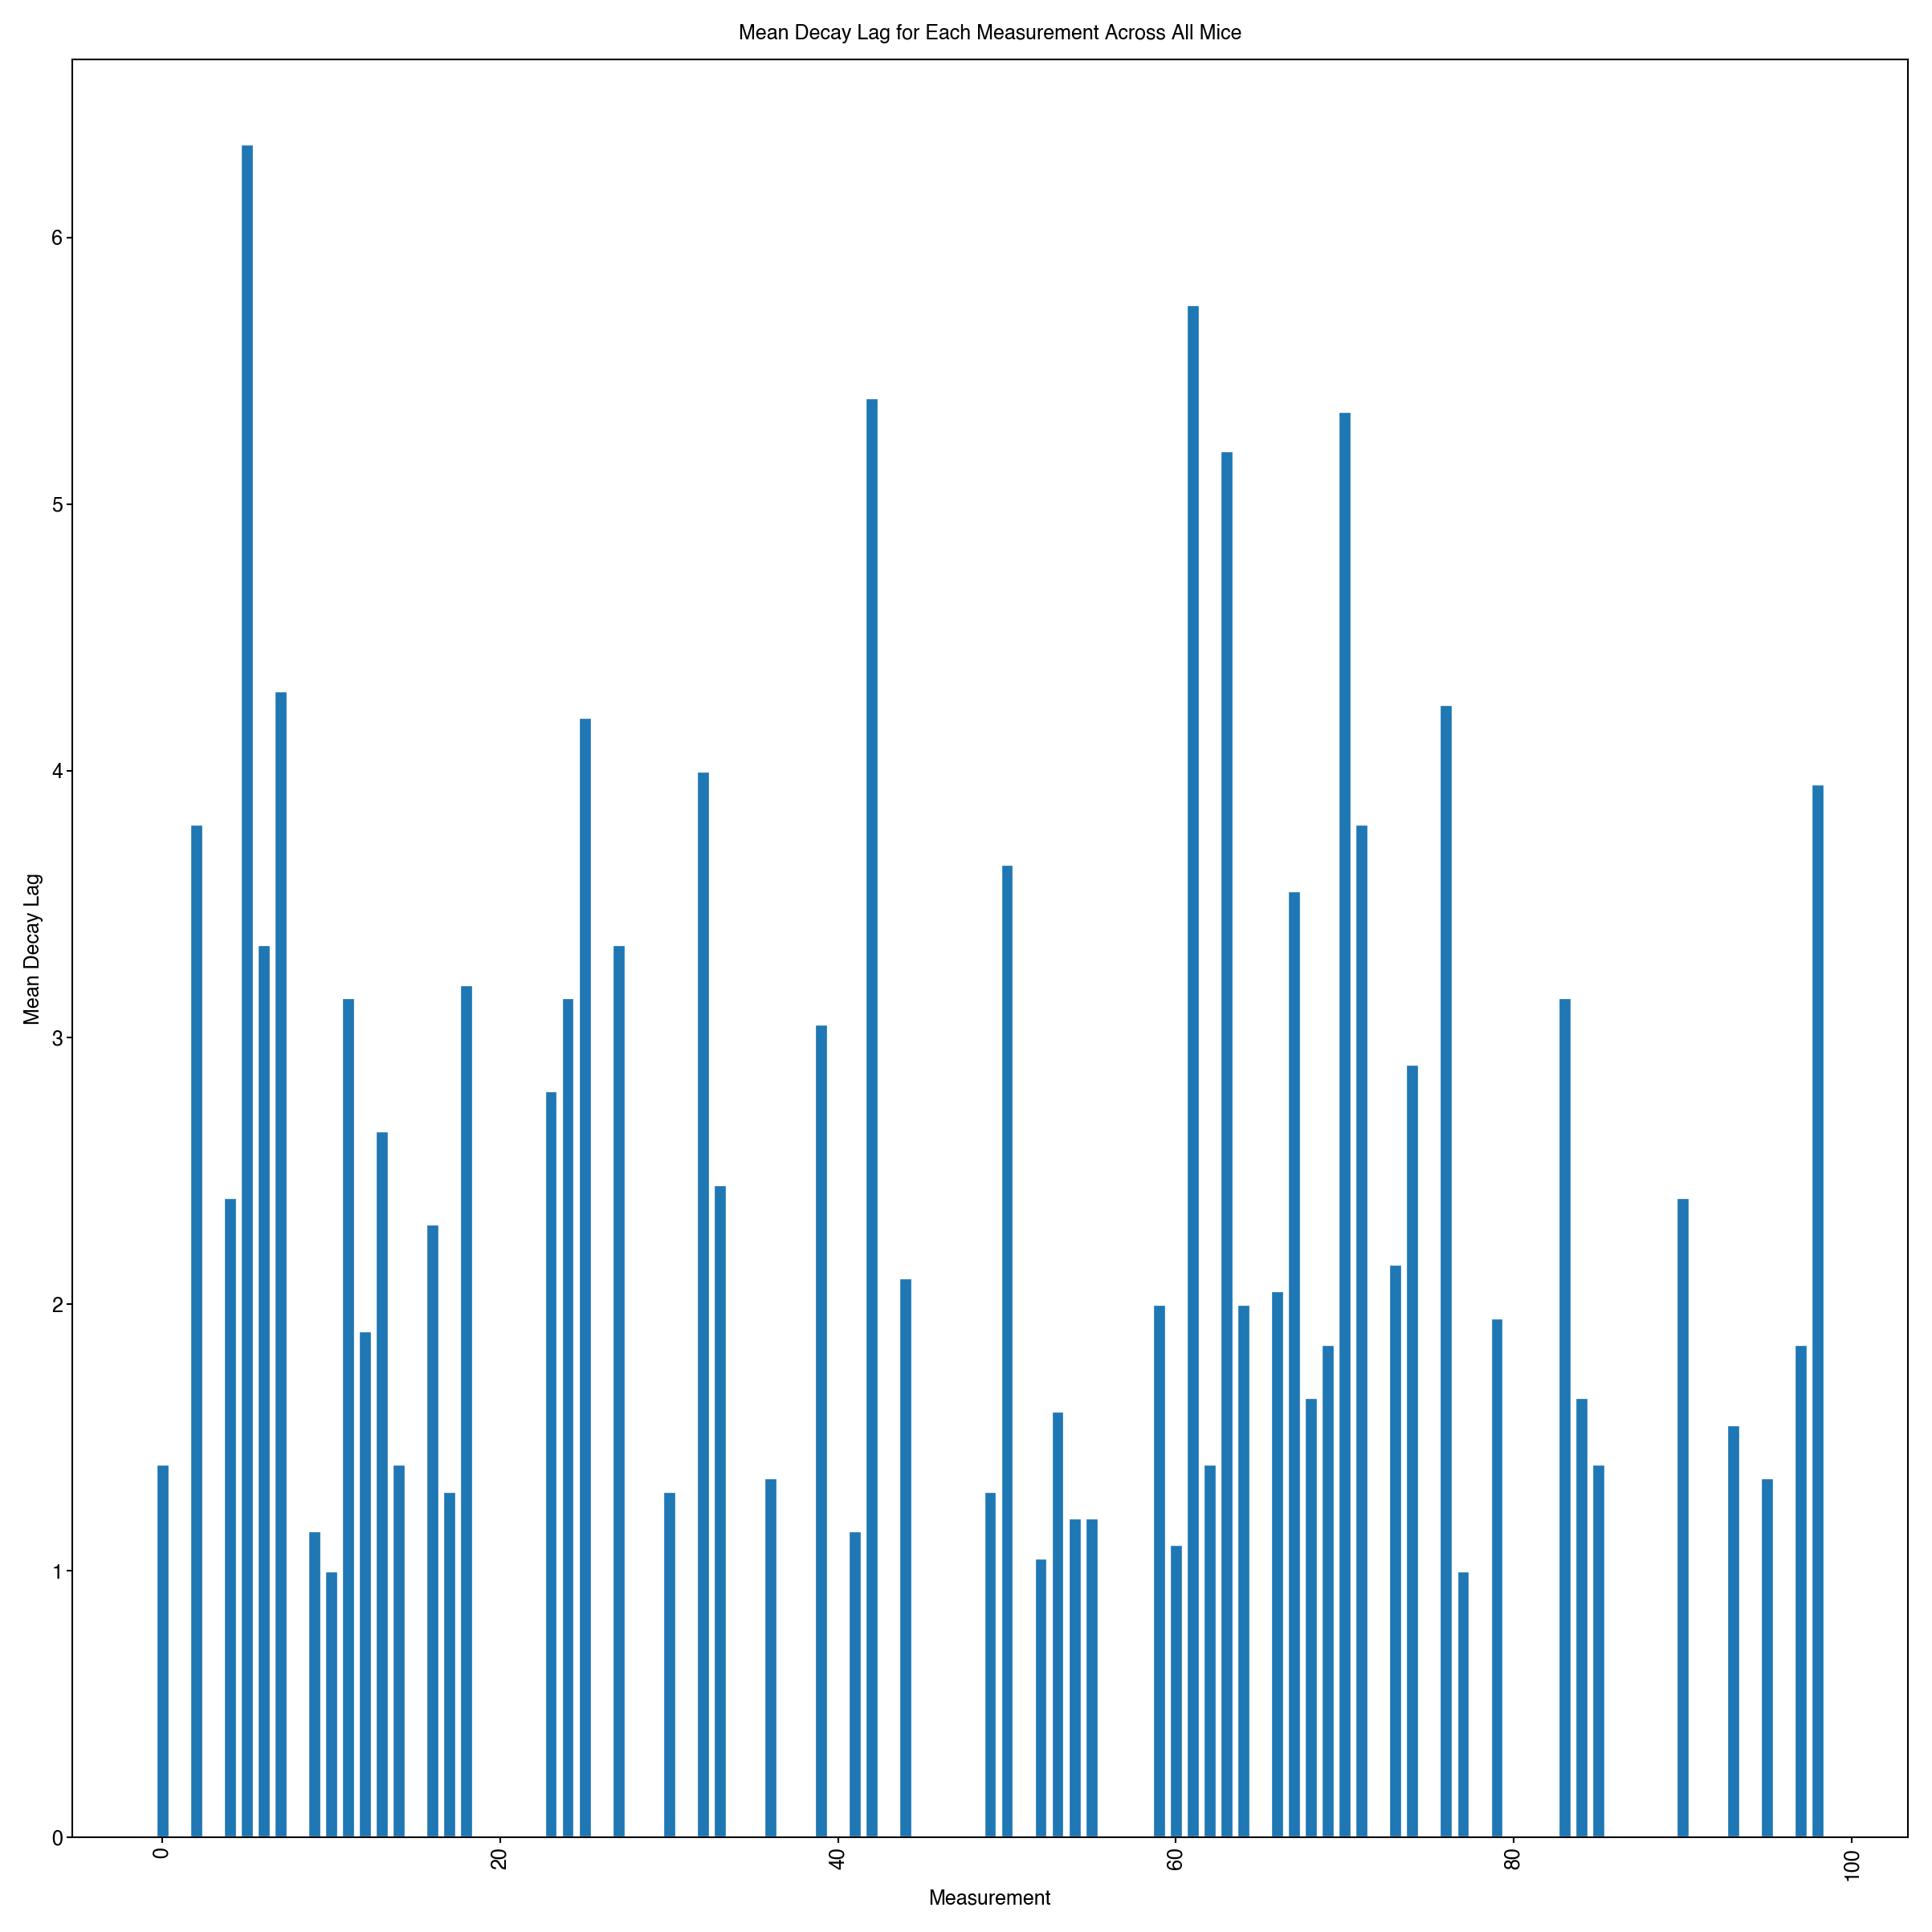

<Figure size 600x600 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt

def plot_aggregated_decay(aggregated_decay):
    measurements = list(aggregated_decay.keys())
    decay_means = list(aggregated_decay.values())
    fig = figure(8, 8)
    #plt.figure(figsize=(12, 8))
    plt.bar(measurements, decay_means)
    plt.xlabel('Measurement')
    plt.ylabel('Mean Decay Lag')
    plt.title('Mean Decay Lag for Each Measurement Across All Mice')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    c = PlotConfig()
    plt.savefig(c.dana_save_path / "fig4"/ 'autocorr_decay_longv2_male.pdf')


plot_aggregated_decay(aggregated_decay)